<a href="https://colab.research.google.com/github/aozdl/Final-Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [1]:
!pip freeze > requirements.txt

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
import statsmodels.api as sm
from IPython import get_ipython
from IPython.display import display
from imblearn.over_sampling import SMOTE
import joblib
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! cp /content/drive/MyDrive/Data Files/4Geeks - Final Project/Ayse/kaggle.json ~/.kaggle/kaggle.json

cp: target '/root/.kaggle/kaggle.json' is not a directory


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
! kaggle datasets download -d utkalk/large-retail-data-set-for-eda

Dataset URL: https://www.kaggle.com/datasets/utkalk/large-retail-data-set-for-eda
License(s): CC0-1.0
 99% 162M/163M [00:01<00:00, 167MB/s]
100% 163M/163M [00:01<00:00, 168MB/s]


In [7]:
!unzip /content/large-retail-data-set-for-eda.zip

Archive:  /content/large-retail-data-set-for-eda.zip
  inflating: retail_data.csv         


#Full EDA

In [10]:
retail_data = pd.read_csv('/content/retail_data.csv')

In [11]:
retail_data.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
0,1,56,Other,High,No,0,No,Divorced,3,Bachelor's,...,33.21,No,Spring,Yes,5,No,High,30,High,40
1,2,69,Female,Medium,No,2,No,Married,2,PhD,...,62.56,No,Summer,Yes,6,No,High,40,Medium,338
2,3,46,Female,Low,No,5,No,Married,3,Bachelor's,...,83.04,Yes,Winter,Yes,2,Yes,Low,89,Medium,61
3,4,32,Female,Low,No,0,No,Divorced,2,Master's,...,50.43,Yes,Winter,No,12,No,Low,12,Low,42
4,5,60,Female,Low,Yes,7,Yes,Divorced,2,Bachelor's,...,36.55,Yes,Summer,Yes,3,No,Medium,31,Low,242


In [12]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 78 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   customer_id                1000000 non-null  int64  
 1   age                        1000000 non-null  int64  
 2   gender                     1000000 non-null  object 
 3   income_bracket             1000000 non-null  object 
 4   loyalty_program            1000000 non-null  object 
 5   membership_years           1000000 non-null  int64  
 6   churned                    1000000 non-null  object 
 7   marital_status             1000000 non-null  object 
 8   number_of_children         1000000 non-null  int64  
 9   education_level            1000000 non-null  object 
 10  occupation                 1000000 non-null  object 
 11  transaction_id             1000000 non-null  int64  
 12  transaction_date           1000000 non-null  object 
 13  product_id   

In [13]:
retail_data.isnull().sum()

,0
customer_id,0
age,0
gender,0
income_bracket,0
loyalty_program,0
...,...
email_subscriptions,0
app_usage,0
website_visits,0
social_media_engagement,0


#storing the Data in a Database

In [14]:
engine = create_engine("sqlite:///retail_data.db")

In [15]:
# Store the dataframe into an SQL table
retail_data.to_sql('retail', con=engine, if_exists='replace', index=False)

1000000

In [16]:
query = '''SELECT customer_id, total_sales, churned FROM retail WHERE churned='Yes' LIMIT 5;'''
result = pd.read_sql(query, con=engine)

result

,customer_id,total_sales,churned
0,5,114.32,Yes
1,6,3372.17,Yes
2,14,4678.45,Yes
3,16,3992.83,Yes
4,17,6936.30,Yes


#Visualization

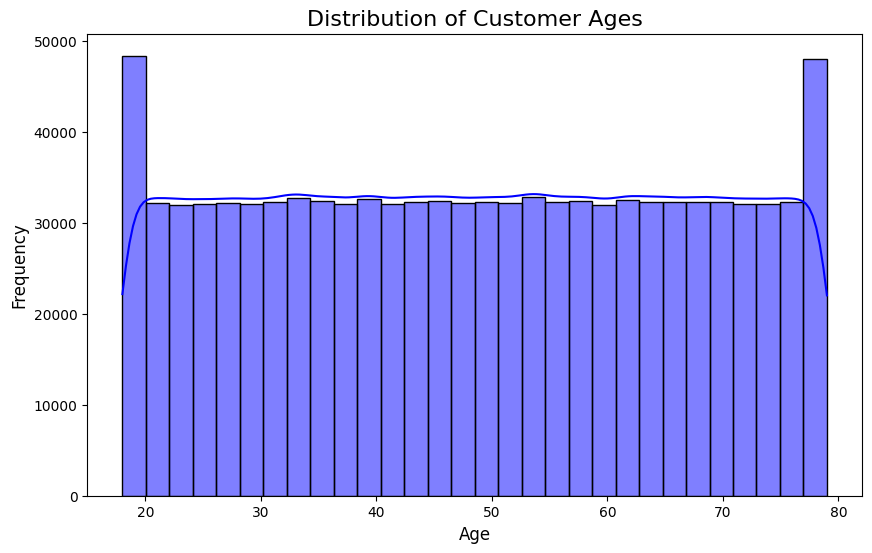

In [17]:
#Distribution of Customer Ages
plt.figure(figsize=(10,6))
sns.histplot(data=retail_data, x='age', bins=30, kde=True, color='blue')
plt.title('Distribution of Customer Ages', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [18]:
# Checking the aggregated data
sales_by_category = retail_data.groupby('product_category')['total_sales'].sum().reset_index()

sales_by_category

,product_category,total_sales
0,Clothing,1.011086e+09
1,Electronics,1.010576e+09
2,Furniture,1.009544e+09
3,Groceries,1.011073e+09
4,Toys,1.013781e+09


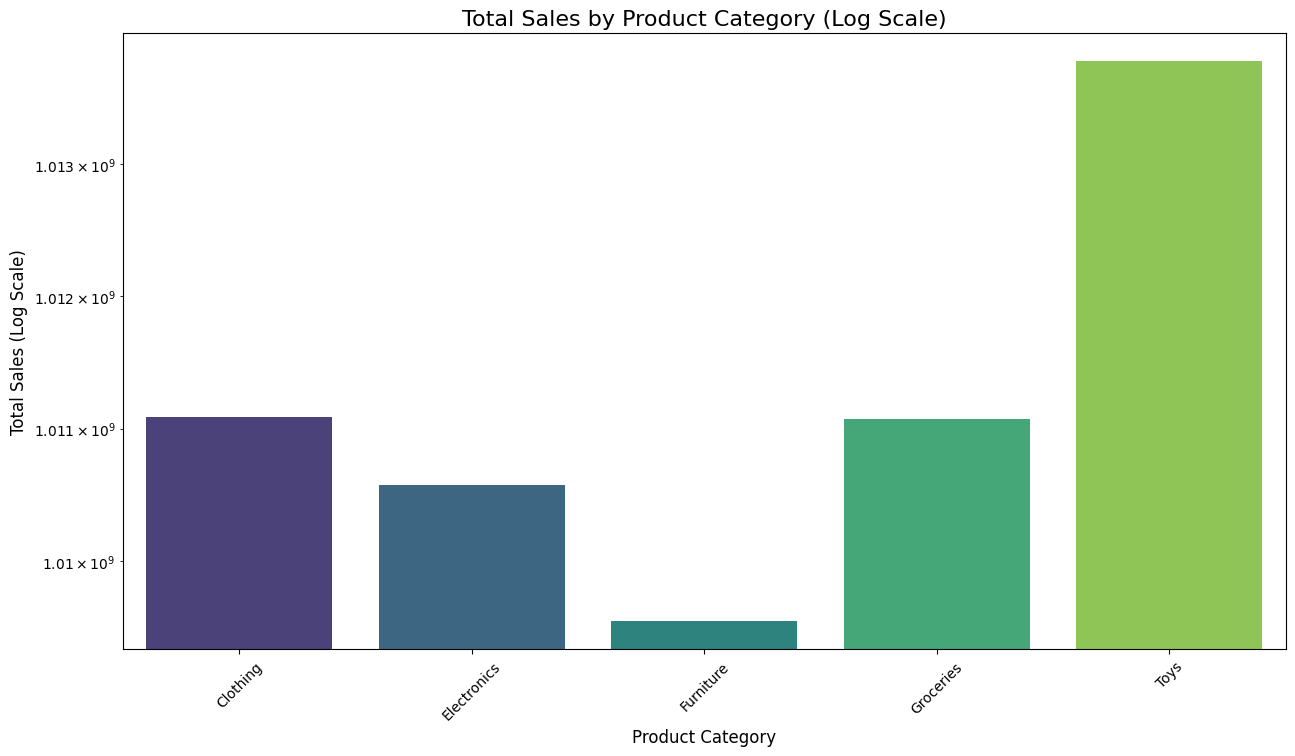

In [19]:
# Normalize sales by converting to percentages
sales_by_category['total_sales_percentage'] = (sales_by_category['total_sales'] / sales_by_category['total_sales'].sum()) * 100

plt.figure(figsize=(15, 8))
sns.barplot(x='product_category', y='total_sales', data=sales_by_category, hue='product_category', palette='viridis')
plt.yscale('log')
plt.title('Total Sales by Product Category (Log Scale)', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Sales (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [20]:
churn_data = retail_data.groupby(['gender'])['churned'].value_counts(normalize=True).unstack().fillna(0)
churn_data['churn_rate'] = churn_data['Yes']
churn_data.reset_index(inplace=True)

churn_data

churned,gender,No,Yes,churn_rate
0,Female,0.500129,0.499871,0.499871
1,Male,0.500313,0.499687,0.499687
2,Other,0.500372,0.499628,0.499628


<ipython-input-21-999bfbe06fcb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='churn_rate', data=churn_data, palette='viridis')


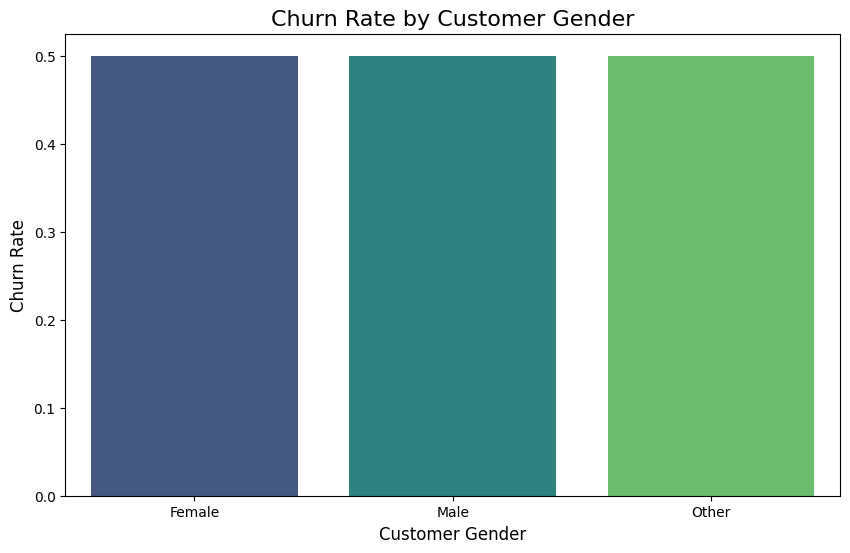

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='churn_rate', data=churn_data, palette='viridis')
plt.title('Churn Rate by Customer Gender', fontsize=16)
plt.xlabel('Customer Gender', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [22]:
# Calculate churn rates
churn_by_loyalty = retail_data.groupby('loyalty_program')['churned'].value_counts(normalize=True).unstack().fillna(0)
churn_by_loyalty['churn_rate'] = churn_by_loyalty['Yes']
churn_by_loyalty.reset_index(inplace=True)

churn_by_loyalty

churned,loyalty_program,No,Yes,churn_rate
0,No,0.500128,0.499872,0.499872
1,Yes,0.500414,0.499586,0.499586


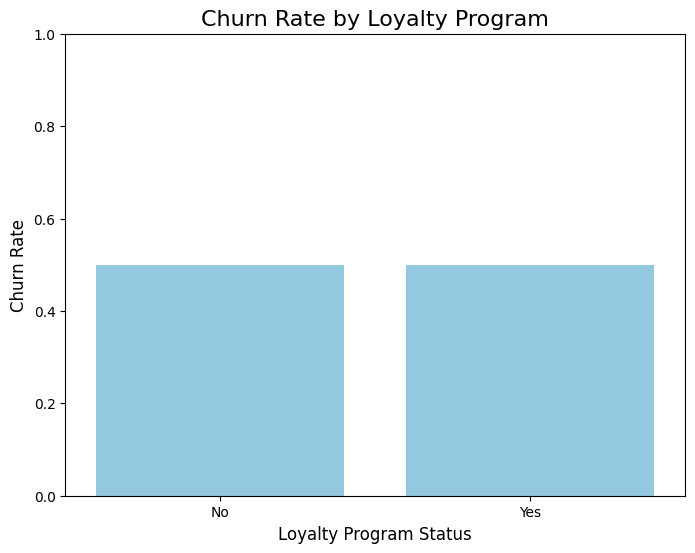

In [23]:
# Customer Churn by Loyalty Program
plt.figure(figsize=(8, 6))
sns.barplot(x='loyalty_program', y='churn_rate', data=churn_by_loyalty, color='skyblue')
plt.title('Churn Rate by Loyalty Program', fontsize=16)
plt.xlabel('Loyalty Program Status', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

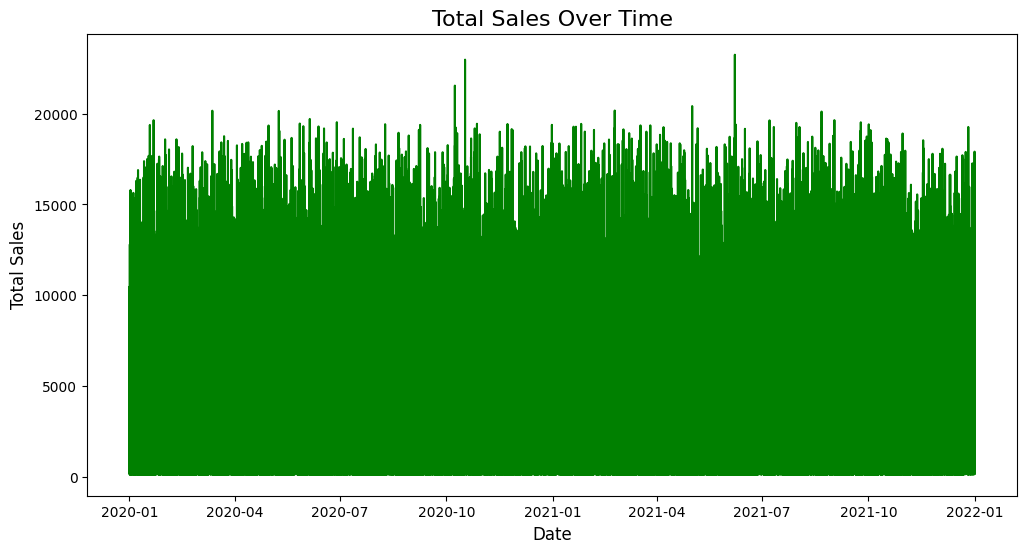

In [24]:
# Total Sales Over Time
retail_data['transaction_date'] = pd.to_datetime(retail_data['transaction_date'])
sales_over_time = retail_data.groupby('transaction_date')['total_sales'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(x='transaction_date', y='total_sales', data=sales_over_time, color='green')
plt.title('Total Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.show()

In [25]:
# Calculate return rate by category
return_rate_by_category = retail_data.groupby('product_category').agg(
    total_returned_items=('total_returned_items', 'sum'),
    total_items_purchased=('total_items_purchased', 'sum')).reset_index()

return_rate_by_category['return_rate'] = return_rate_by_category['total_returned_items'] / return_rate_by_category['total_items_purchased']
return_rate_by_category['return_rate'] = return_rate_by_category['return_rate'].fillna(0)

return_rate_by_category

,product_category,total_returned_items,total_items_purchased,return_rate
0,Clothing,900251,49918455,0.018034
1,Electronics,899057,49927088,0.018007
2,Furniture,897348,49996653,0.017948
3,Groceries,899945,50078988,0.017971
4,Toys,901541,50121579,0.017987


<ipython-input-26-04908db206bc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_category', y='return_rate', data=return_rate_by_category, palette='viridis')
<ipython-input-26-04908db206bc>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()])


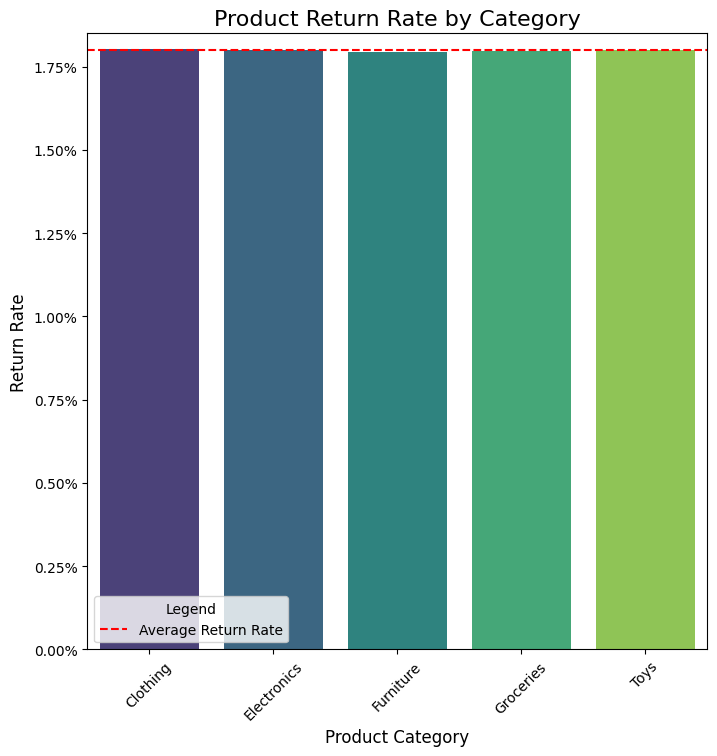

In [26]:
# Plot the Product Return Rate by Category
plt.figure(figsize=(8, 8))
sns.barplot(x='product_category', y='return_rate', data=return_rate_by_category, palette='viridis')
plt.title('Product Return Rate by Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Return Rate', fontsize=12)
plt.xticks(rotation=45)

average_return_rate = return_rate_by_category['return_rate'].mean()
plt.axhline(average_return_rate, color='red', linestyle='--', label='Average Return Rate')
plt.legend(title='Legend')

plt.ylim(0, 0.0185)
plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.show()

#Churn Prediction

In [27]:
retail_data = pd.read_csv('/content/retail_data.csv')

In [28]:
# Drop non-numeric columns
non_numeric_columns = [
    'transaction_date', 'purchase_frequency', 'last_purchase_date',
    'preferred_store', 'product_name', 'product_brand',
    'product_size', 'product_color', 'product_material',
    'product_manufacture_date', 'product_expiry_date',
    'promotion_type', 'promotion_start_date',
    'promotion_end_date', 'promotion_effectiveness',
    'promotion_channel', 'promotion_target_audience',
    'customer_city', 'customer_state',
    'store_city', 'store_state']

In [29]:
X = retail_data.drop(non_numeric_columns, axis=1, errors='ignore')
y = retail_data['churned']

In [30]:
# Handle categorical variables automatically
X = pd.get_dummies(X, drop_first=True)
y = y.map({'Yes': 1, 'No': 0})

In [31]:
X = X.dropna()
y = y[X.index]

In [32]:
# Print shape after preprocessing
print("Shape after preprocessing:", X.shape)

Shape after preprocessing: (1000000, 80)


In [33]:
# Check the shape and data types after encoding
print("Shape after encoding:", retail_data.shape)
print("Data types after encoding:\n", retail_data.dtypes)

Shape after encoding: (1000000, 78)
Data types after encoding:
 customer_id                  int64
age                          int64
gender                      object
income_bracket              object
loyalty_program             object
                             ...  
email_subscriptions         object
app_usage                   object
website_visits               int64
social_media_engagement     object
days_since_last_purchase     int64
Length: 78, dtype: object


In [34]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [35]:
print(f"Shape of X after SMOTE:{X_resampled.shape}")
print(f"Shape of y after SMOTE:{y_resampled.shape}")

Shape of X after SMOTE:(1000542, 80)
Shape of y after SMOTE:(1000542,)


In [36]:
# Check the distribution of the target variable
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
churned
0    500271
1    500271
Name: count, dtype: int64


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [38]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
y_pred = model.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99958
           1       1.00      1.00      1.00    100151

    accuracy                           1.00    200109
   macro avg       1.00      1.00      1.00    200109
weighted avg       1.00      1.00      1.00    200109



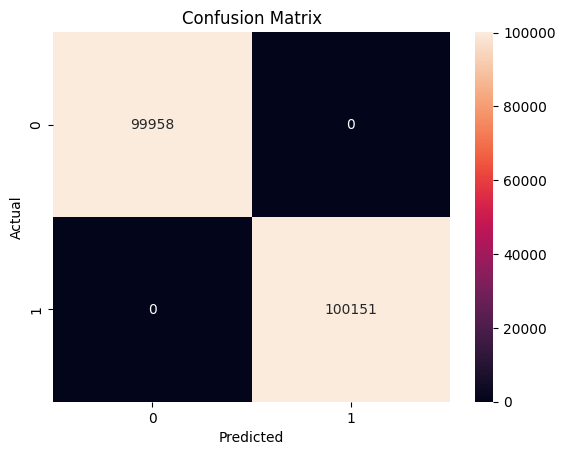

In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [42]:
#param_grid = {
    #'n_estimators': [100, 200],
   #'max_depth': [10, 20],
    #'min_samples_split': [2, 5],}

#grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
#grid_search.fit(X_train, y_train)

#print("Best parameters:", grid_search.best_params_)///

In [43]:
# Save your model
joblib.dump(model, 'model.pkl')

['model.pkl']

In [44]:
from google.colab import files

if os.path.exists('app.py'):
  files.download('app.py')
else:
  print("The file 'app.py' does not exist in the current directory.")

The file 'app.py' does not exist in the current directory.
